In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers



Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


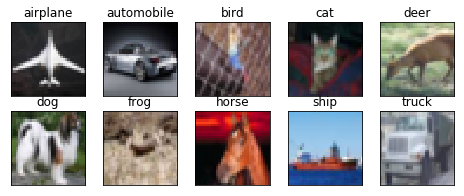

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# 6A Model

In [0]:
# Define the model


model = Sequential()
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same',kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())

model.add(Convolution2D(48, 3, 3, activation='relu', border_mode='same',kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3,3, activation='relu',  kernel_regularizer=regularizers.l2(0.001),border_mode='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1, 1))

model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same',kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001),border_mode='same'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001),border_mode='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 1, 1))

model.add(Convolution2D(128, 3, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001), border_mode='same'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3, kernel_regularizer=regularizers.l2(0.001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())
model.add(Activation('softmax'))




W0702 03:09:38.489906 139918556620672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
W0702 03:09:38.526754 139918556620672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 03:09:38.532948 139918556620672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W070

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 48)        13872     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        27712     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.callbacks import ModelCheckpoint

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


best_model_weights = '6A_with_cutout_retrained_best_weights.h5'
checkpointer = ModelCheckpoint(filepath='../content/drive/My Drive/EVA/Saved_models/'+best_model_weights, monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)



W0702 03:09:59.516882 139918556620672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=781, epochs=100)`
  app.launch_new_instance()
W0702 03:09:59.778862 139918556620672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
781/781 [==============================] - 34s 43ms/step - loss: 2.0309 - acc: 0.3846 - val_loss: 1.7411 - val_acc: 0.4743

Epoch 00001: val_acc improved from -inf to 0.47430, saving model to ../content/drive/My Drive/EVA/Saved_models/6A_with_cutout_retrained_best_weights.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0023076923.
781/781 [==============================] - 29s 37ms/step - loss: 1.5602 - acc: 0.5382 - val_loss: 1.8284 - val_acc: 0.5110

Epoch 00002: val_acc improved from 0.47430 to 0.51100, saving model to ../content/drive/My Drive/EVA/Saved_models/6A_with_cutout_retrained_best_weights.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.001875.
781/781 [==============================] - 29s 37ms/step - loss: 1.4016 - acc: 0.6010 - val_loss: 1.4283 - val_acc: 0.5853

Epoch 00003: val_acc improved from 0.51100 to 0.58530, saving model to 

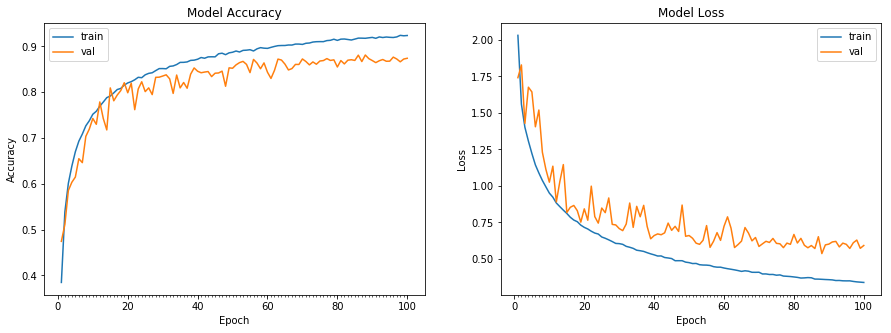

Accuracy on test data is: 87.39


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.30* epoch), 10)

datagen = ImageDataGenerator(rotation_range=5,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,zoom_range=0.07,horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 64),samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels),callbacks=[LearningRateScheduler(scheduler, verbose=1),checkpointer],verbose=1)

end = time.time()

  
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history


plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))



## Saving the trained model and weights to google drive

In [0]:
# Save the trained weights in to .h5 format

file_name_to_save_model = "6A_with_cutout__model_final_retrained.h5"
file_name_to_save_model_weights = "6A_with_cutout__final_retrained.h5"
model.save("/content/drive/My Drive/EVA/Saved_models/"+file_name_to_save_model)
model.save_weights("/content/drive/My Drive/EVA/Saved_models/"+file_name_to_save_model_weights)
print("Saved model to drive")

Saved model to drive


## Saving trained model and weights locally

In [0]:
model.save(file_name_to_save_model)
model.save_weights(file_name_to_save_model_weights)

In [0]:
score = model.evaluate(test_features, test_labels, batch_size=128)
print (score[1])

10000/10000 [==============================] - 1s 134us/step
0.8739
